In [2]:
import numpy as np
import torch
import datetime
import os
import base64
import pandas as pd
from collections import Counter
from tqdm import tqdm
import sqlite3
from utils.data_analysis import get_overlap_undefined,get_direction_info
from utils.types import Direction
import matplotlib.pyplot as plt
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', 1000)  # Adjust the number as needed
pd.set_option('display.max_columns', 1000)  # Adjust the number as needed

FRAME_NUMBER = 15
db = '/home/diego/mydrive/results/1/10/8/apumanque_entrada_2_20240703_0900/apumanque_entrada_2_20240703_0900_bbox.db'
conn = sqlite3.connect(db)
bbox = pd.read_sql('SELECT * FROM bbox_raw', conn)


In [19]:
# db = '/home/diego/mydrive/results/1/10/8/apumanque_entrada_2_20240703_0900/apumanque_entrada_2_20240703_0900_bbox.db'
# queue_video_id = 37
# event_type = 'In'

# conn = sqlite3.connect(db)
# bbox = pd.read_sql('SELECT * FROM bbox_raw', conn)
# filtered_df = bbox[bbox['direction'] == 'In']
# result = filtered_df.groupby('id').first().reset_index()
# result = result[['id', 'time_video']]
# result_list = result.to_dict(orient='records')

#id, event_type, queue_video_id, time_video, created_at, updated_at


import sqlite3
import pandas as pd
from datetime import datetime, timedelta
import pymysql


def prepare_event_timestamps_data(db, queue_video_id, start_video_time):
    event_type = 'In'
    start_time = datetime.strptime(start_video_time, '%H:%M:%S')

    conn = sqlite3.connect(db)
    bbox = pd.read_sql('SELECT * FROM bbox_raw', conn)
    conn.close()

    filtered_df = bbox[bbox['direction'] == event_type]
    result = filtered_df.groupby('id').first().reset_index()
    result = result[['id', 'time_video']]
    result_list = result.to_dict(orient='records')

    for record in result_list:
        time_video = datetime.strptime(record['time_video'], '%H:%M:%S')
        adjusted_time_video = (start_time + timedelta(hours=time_video.hour, minutes=time_video.minute, seconds=time_video.second)).time()
        record['event_type'] = event_type
        record['queue_video_id'] = queue_video_id
        record['adjusted_time_video'] = adjusted_time_video
        record['created_at'] = datetime.now()
        record['updated_at'] = datetime.now()

    return result_list

def save_to_mysql(data, mysql_config):
    conn = pymysql.connect(**mysql_config)
    cursor = conn.cursor()

    insert_query = '''
    INSERT INTO event_timestamps (bbox_id, event_type, queue_video_id,adjusted_time_video, time_video, created_at, updated_at)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
    '''

    for record in data:
        cursor.execute(insert_query, (
            record['id'],
            record['event_type'],
            record['queue_video_id'],
            record['adjusted_time_video'],
            record['time_video'],
            record['created_at'],
            record['updated_at']
        ))

    conn.commit()
    cursor.close()
    conn.close()

db_path = '/home/diego/mydrive/results/1/10/8/apumanque_entrada_2_20240707_0900/apumanque_entrada_2_20240707_0900_bbox.db'
queue_video_id = 43
start_video_time = '09:00:00'
mysql_config = {
    'user': 'admin',
    'password': 'root',
    'host': '127.0.0.1',
    'database': 'mivo'
}

data = prepare_event_timestamps_data(db_path, queue_video_id, start_video_time)
save_to_mysql(data, mysql_config)


OperationalError: unable to open database file

In [ ]:
db = '/home/diego/mydrive/results/1/10/8/apumanque_entrada_2_20240702_0900/apumanque_entrada_2_20240702_0900_bbox.db'
conn = sqlite3.connect(db)
bbox = pd.read_sql('SELECT * FROM bbox_raw', conn)
ID = 92
bbox_filter_by_id = bbox[bbox['id'] == ID].sort_values(by='frame_number')
final_direction = bbox_filter_by_id['direction'].iloc[-1]
diff_frames = bbox_filter_by_id['frame_number'].iloc[-1] - bbox_filter_by_id['frame_number'].iloc[0]
time_diff_seconds = diff_frames / 15

plt.figure(figsize=(10, 6))
positive_distance = bbox_filter_by_id['distance_to_center'] > 0
plt.scatter(bbox_filter_by_id[positive_distance]['frame_number'], bbox_filter_by_id[positive_distance]['distance_to_center'],c='blue', s=10, alpha=0.6, label=f"ID {ID} In")
plt.scatter(bbox_filter_by_id[~positive_distance]['frame_number'], bbox_filter_by_id[~positive_distance]['distance_to_center'],c='red', s=10, alpha=0.6, label=f"ID {ID} Out")

# Set labels and title
plt.xlabel('Frame Number')
plt.ylabel('Distance to Center')
plt.title(f"ID {ID}: {len(bbox_filter_by_id)} frames ({bbox_filter_by_id['time_video'].iloc[0]}) seconds: {time_diff_seconds:.1f} Direction: {final_direction}")

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--')

# Customize x-axis
plt.xlim(bbox_filter_by_id['frame_number'].min(), bbox_filter_by_id['frame_number'].max())
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

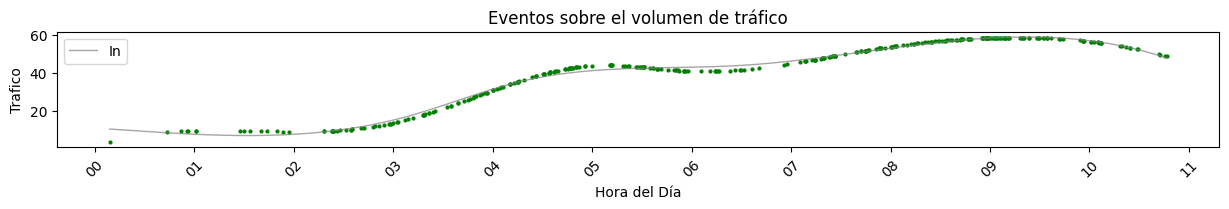

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import UnivariateSpline

# Calculate aggregated information including transitions, potential ID switches, and First Frame Number
def calculate_aggregated_info(group):
    number_of_frames = group['frame_number'].nunique()
    first_frame_number = group['frame_number'].min()
    first_frame_time = group['time_video'].min()
    event_duration = number_of_frames // 15
    # Get the most frequent direction for the ID
    direction = group['direction'].mode()[0] if not group['direction'].mode().empty else np.nan
    
    return pd.Series({
        'Number of Frames': number_of_frames,
        'Event Duration': event_duration,
        'First Frame Number': first_frame_number,
        'First Frame Time': first_frame_time,
        'Direction': direction  # Include the direction column
    })

# Reset index to ensure 'id' is not both an index level and a column label
db = '/home/diego/mydrive/results/1/10/8/apumanque_entrada_2_20240702_0900/apumanque_entrada_2_20240702_0900_bbox.db'
conn = sqlite3.connect(db)
bbox = pd.read_sql('SELECT * FROM bbox_raw', conn)

# Apply the function to each ID group and create the aggregated DataFrame
aggregated_info = bbox.groupby('id').apply(calculate_aggregated_info).reset_index()

# Define the start time of the video (change this as needed)
video_start_time = pd.Timestamp('08:50:33')  # The time the video starts, e.g., '08:50:33'

# Convert 'First Frame Time' to actual timestamps based on the start time
aggregated_info['First Frame Actual Time'] = pd.to_datetime(aggregated_info['First Frame Time'], format='%H:%M:%S') + (video_start_time - pd.Timestamp('1970-01-01'))

# Calculate traffic volume per 30-minute interval
aggregated_info['Time Interval'] = aggregated_info['First Frame Actual Time'].dt.floor('30T')
traffic_volume = aggregated_info.groupby('Time Interval')['id'].count()

# Convert time intervals to numeric values for fitting the trend line
time_numeric = np.arange(len(traffic_volume))

# Fit a spline with smoothness control and boundary conditions
spline = UnivariateSpline(time_numeric, traffic_volume.values, s=500, k=3)
time_smooth = np.linspace(time_numeric.min(), time_numeric.max(), 500)
trendline_smooth = spline(time_smooth)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(15, 1.5))  # Adjusting the height to 1.5 inches to match 150 pixels at 100 dpi

# Variable to control the direction to be displayed as green dots
direction_to_display = 'In'

# Collect green dot positions for the specified direction
event_times = []
trend_y_values = []

# ID to highlight
highlight_id = 15

# Interpolate trend line values at exact event times and plot them
for _, row in aggregated_info.iterrows():
    event_time = row['First Frame Actual Time']
    # Calculate the relative position of the event time in the traffic volume index
    relative_position = (event_time - traffic_volume.index[0]) / pd.Timedelta(minutes=60)
    if 0 <= relative_position < len(time_numeric):
        trend_y = spline(relative_position)
        
        if row['Direction'] == direction_to_display:
            event_times.append(event_time)
            trend_y_values.append(trend_y)
            if row['id'] == highlight_id:
                ax.plot([event_time], [trend_y], color='red', marker='o', markersize=5)
                ax.axvline(x=event_time, color='red', linestyle='--', linewidth=1)
            else:
                ax.plot([event_time], [trend_y], color='green', marker='o', markersize=2)

# Create a new trend line based on green dot positions
event_times_numeric = mdates.date2num(event_times)
new_spline = UnivariateSpline(event_times_numeric, trend_y_values, s=500, k=3)
new_time_smooth = np.linspace(event_times_numeric.min(), event_times_numeric.max(), 500)
new_trendline_smooth = new_spline(new_time_smooth)

# Plot the new trend line based on green dots
ax.plot(mdates.num2date(new_time_smooth), new_trendline_smooth, color='grey', alpha=0.7, linewidth=1, label=direction_to_display)

# Set the title and labels
ax.set_title('Eventos sobre el volumen de tráfico')
ax.set_xlabel('Hora del Día')
ax.set_ylabel('Trafico')

# Format the x-axis to show only hours
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
ax.legend()

plt.show()


In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import linregress


def create_plot(df, primary_id,unique_ids, intersecting_id_colors=['green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown']):
    slopes = {}
    for unique_id in unique_ids:
        id_data = df[df['id'] == unique_id]
        slope, intercept, r_value, p_value, std_err = linregress(id_data['frame_number'], id_data['distance_to_center'])
        slopes[unique_id] = slope
        
    reference_slope = slopes[primary_id]  # You need to define this
    normalized_slopes = {unique_id: slope / reference_slope for unique_id, slope in slopes.items()}
    
    
    
    scaled_slopes = {}
    for unique_id in unique_ids:
        id_data = df[df['id'] == unique_id]
        min_y = id_data['distance_to_center'].min()
        max_y = id_data['distance_to_center'].max()
        scaled_slopes[unique_id] = (slopes[unique_id] - min_y) / (max_y - min_y) if max_y != min_y else 0
    
    
    standardized_slopes = {}
    for unique_id in unique_ids:
        id_data = df[df['id'] == unique_id]
        mean_y = id_data['distance_to_center'].mean()
        std_y = id_data['distance_to_center'].std()
        standardized_slopes[unique_id] = (slopes[unique_id] - mean_y) / std_y if std_y != 0 else 0

    
    
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the size as needed

    # Filter the dataframe for the primary ID and sort it
    df_primary_id = df[df['id'] == primary_id].sort_values(by='frame_number')

    # Scatter plot for the primary ID with different colors for positive and negative distances
    positive_distance = df_primary_id['distance_to_center'] > 0
    ax.scatter(df_primary_id[positive_distance]['frame_number'], df_primary_id[positive_distance]['distance_to_center'],c='blue', s=10, alpha=0.6, label=f'ID {primary_id} In')
    ax.scatter(df_primary_id[~positive_distance]['frame_number'], df_primary_id[~positive_distance]['distance_to_center'],c='red', s=10, alpha=0.6, label=f'ID {primary_id} Out')

    # Calculate the time frame start and end
    timeframe_start = df['frame_number'].min()
    timeframe_end = df['frame_number'].max()

    # Identify other intersecting IDs within this timeframe
    intersecting_ids = df[(df['frame_number'] >= timeframe_start) & (df['frame_number'] <= timeframe_end) &  (df['id'] != primary_id)]['id'].unique()

    # Plot data for each intersecting ID within the timeframe
    for idx, other_id in enumerate(intersecting_ids):
        df_other_id = df[(df['id'] == other_id) &  (df['frame_number'] >= timeframe_start) &  (df['frame_number'] <= timeframe_end)]
        color = intersecting_id_colors[idx % len(intersecting_id_colors)]
        ax.scatter(df_other_id['frame_number'], df_other_id['distance_to_center'], c=color, s=20, edgecolor='k', label=f'ID {other_id}')
    
    # Plot formatting
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.set_xlim(timeframe_start - 10, timeframe_end + 10)  # A little space around the edges
    ax.set_ylim(df['distance_to_center'].min() - 10, df['distance_to_center'].max() + 10)

    # Construct the title to include the ID and its timeframe
    duration = timeframe_end - timeframe_start
    title_text = f'ID {primary_id}: #{duration} '
    ax.set_title(title_text, color='red')

    ax.set_xlabel('Frame Number')
    ax.set_ylabel('Distance to Center')
    ax.legend(loc='upper left', fontsize='small')
    slopes_text = ', '.join([f'{key}: {value:.3f}' for key, value in slopes.items()])
    fig.text(0.5, 1, f"{slopes_text} = slopes", ha='center', va='center', fontsize=10, color='green', style='italic')  # Adjust the position and style as needed
    
    normalized_slopes_text = ', '.join([f'{key}: {value:.3f}' for key, value in normalized_slopes.items()])
    fig.text(0.5, -0.02, f"{normalized_slopes_text} = normalized", ha='center', va='center', fontsize=10, color='blue', style='italic')  # Adjust the position and style as needed
    
    scaled_slopes_text = ', '.join([f'{key}: {value:.3f}' for key, value in scaled_slopes.items()])
    fig.text(0.5, -0.05, f"{scaled_slopes_text} = scaled", ha='center', va='center', fontsize=10, color='blue', style='italic')  # Adjust the position and style as needed
    
    standardized_slopes_text = ', '.join([f'{key}: {value:.3f}' for key, value in standardized_slopes.items()])
    fig.text(0.5, -0.08, f"{standardized_slopes_text} = standardized", ha='center', va='center', fontsize=10, color='blue', style='italic')  # Adjust the position and style as needed
    
    
    plt.tight_layout()
    plt.show()

In [4]:
from scipy.stats import pearsonr
import seaborn as sns

query = 'SELECT * FROM overlap_results WHERE count = 1'
overlap_results = pd.read_sql(query, conn)

ids_overlap = list(overlap_results['id_overlap'])
query = 'SELECT id, distance_to_center, frame_number FROM bbox_raw WHERE id IN ({})'.format(', '.join(['?']*len(ids_overlap)))
bboxes = pd.read_sql(query, conn, params=ids_overlap)

def calculate_similarity(df, ids):
    correlation_matrix = np.zeros((len(ids), len(ids)))
    
    for i, id1 in enumerate(ids):
        for j, id2 in enumerate(ids):
            if i >= j:
                continue
            series1 = df[df['id'] == id1]['distance_to_center'].values
            series2 = df[df['id'] == id2]['distance_to_center'].values
            
            # Make series the same length
            min_length = min(len(series1), len(series2))
            series1 = series1[:min_length]
            series2 = series2[:min_length]
            
            # Calculate Pearson Correlation Coefficient
            corr, _ = pearsonr(series1, series2)
            correlation_matrix[i, j] = corr
            correlation_matrix[j, i] = corr  # Matrix is symmetrical
    
    return correlation_matrix

# Usage:
# ids_overlap could be a list of all unique ids you want to compare
similarity_matrix = calculate_similarity(bboxes, ids_overlap)



DatabaseError: Execution failed on sql 'SELECT * FROM overlap_results WHERE count = 1': no such table: overlap_results

In [ ]:
import pandas as pd
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

primary_id = 3625
query = 'SELECT * FROM overlap_results'
overlap_results = pd.read_sql(query, conn)

overlap_results_only_id = overlap_results[overlap_results['id'] == primary_id]
ids_overlap = list(overlap_results_only_id['id_overlap'])
ids_overlap.append(primary_id)  # Append the integer version of id

query = 'SELECT id, distance_to_center, frame_number FROM bbox_raw WHERE  id IN ({})'.format(', '.join(['?']*len(ids_overlap)))
bbox2 = pd.read_sql(query, conn, params=ids_overlap)


def compare_two_curves(id1, id2, df):
    # Extract the series for the two IDs
    series1 = df[df['id'] == id1][['frame_number', 'distance_to_center']].sort_values('frame_number')
    series2 = df[df['id'] == id2][['frame_number', 'distance_to_center']].sort_values('frame_number')

    # Convert to numpy arrays
    series1 = series1.to_numpy()
    series2 = series2.to_numpy()

    # Apply DTW
    distance, path = fastdtw(series1, series2, dist=euclidean)
    
    return distance, path

# Replace 'id1' and 'id2' with the actual IDs you want to compare
id1 = ids_overlap[0]  # Replace with the first ID you want to compare
id2 = ids_overlap[1]  # Replace with the second ID you want to compare

# Use the compare_two_curves function
dtw_distance, dtw_path = compare_two_curves(id1, id2, bbox2)

print(f"DTW distance between ID {id1} and ID {id2}: {dtw_distance}")


#plot_path = create_plot(bbox2,primary_id, ids_overlap)

### Standarizar todas las pentiednes

In [5]:
#### NUEVO #### 

from scipy.stats import linregress

# Assuming 'bbox2' is loaded with the relevant data
query = 'SELECT id, distance_to_center, frame_number FROM bbox_raw'
bbox2 = pd.read_sql(query, conn)
# 1. Calculate slopes for each ID
slopes = {}
for id_group, group_data in bbox2.groupby('id'):
    slope, intercept, r_value, p_value, std_err = linregress(group_data['frame_number'], group_data['distance_to_center'])
    slopes[id_group] = slope


valid_slopes = {k: v for k, v in slopes.items() if not np.isnan(v)}
valid_slopes2 = {k: v for k, v in slopes.items() if np.isnan(v)}
average_slope = sum(valid_slopes.values()) / len(valid_slopes)
normalized_slopes = {id_group: slope / average_slope for id_group, slope in slopes.items()}
valid_slopes2


{}

#### Filter undefined logic 1 count - 1

In [6]:
ids_overlap_total = overlap_results[overlap_results['count'] == 1]['id_overlap'].unique().tolist()

query = 'SELECT id, distance_to_center, frame_number FROM bbox_raw WHERE id IN ({})'.format(', '.join(['?']*len(ids_overlap_total)))

bbox_overlap = pd.read_sql(query, conn, params=ids_overlap_total)

df = bbox_overlap.sort_values(by=['id', 'frame_number'])
df['previous_distance_to_center'] = df.groupby('id')['distance_to_center'].shift(1)
crosses_zero = df.apply(lambda row: (row['distance_to_center'] < 0 < row['previous_distance_to_center']) or (row['distance_to_center'] > 0 > row['previous_distance_to_center']), axis=1)
ids_crossing_zero = df[crosses_zero]['id'].unique()

overlap_results[overlap_results['id_overlap'].isin(ids_crossing_zero)]['id'].unique().tolist()

NameError: name 'overlap_results' is not defined

### None Analysis 2.0

In [7]:
import pandas as pd
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

#primary_id = 2469
count_overlaps = 1
query = """
    SELECT
    or2.id as base_id, 
    br.id,
    CASE WHEN or2.id = br.id THEN 1 ELSE 0 END as primary_id, 
    or2.id_overlap,
    br.frame_number,
    br.distance_to_center,
    or2.count,
    or2.direction
FROM 
    overlap_results AS or2 
LEFT JOIN 
    bbox_raw AS br ON br.id = or2.id OR br.id = or2.id_overlap 
WHERE 
    or2.count = ?
"""



bbox_analysis = pd.read_sql(query, conn, params=(count_overlaps,))



## Only the id that got primary_id = 1 must be in the top level of the dictionary, and for every id that got primary_id = 1 must be a id_overlap associate it with

# {
# 	primary_id : {
# 		direction : 'In',
# 		data : [{frame_number: 1, distance_to_center: 10}, {frame_number: 2, distance_to_center: 20}]
# 		id_overlap : {
# 			1 : {
# 				direction : 'Undefined',
# 				data : [{frame_number: 1, distance_to_center: 10}, {frame_number: 2, distance_to_center: 20}]
# 			}
# 		}
# 	}
# }

#create_plot(bbox_analysis,primary_id, bbox_analysis['id'].unique().tolist())


# from scipy.stats import linregress

# for id_group, group_data in bbox_analysis[bbox_analysis['direction'] == 'In'].groupby('id'):
#     slope, intercept, r_value, p_value, std_err = linregress(group_data['frame_number'], group_data['distance_to_center'])
#     slopes[id_group] = slope


# valid_slopes = {k: v for k, v in slopes.items() if not np.isnan(v)}
# #valid_slopes2 = {k: v for k, v in slopes.items() if np.isnan(v)}
# average_slope = sum(valid_slopes.values()) / len(valid_slopes)
# normalized_slopes = {id_group: slope / average_slope for id_group, slope in slopes.items()}
# normalized_slopes

DatabaseError: Execution failed on sql '
    SELECT
    or2.id as base_id, 
    br.id,
    CASE WHEN or2.id = br.id THEN 1 ELSE 0 END as primary_id, 
    or2.id_overlap,
    br.frame_number,
    br.distance_to_center,
    or2.count,
    or2.direction
FROM 
    overlap_results AS or2 
LEFT JOIN 
    bbox_raw AS br ON br.id = or2.id OR br.id = or2.id_overlap 
WHERE 
    or2.count = ?
': no such table: overlap_results

In [8]:
structured_data = {}
data_slope = []

# Group the dataframe by 'base_id' to process each primary_id group
for base_id, group in bbox_analysis.groupby('base_id'):
    primary_data = group[group['primary_id'] == 1]
    overlap_data = group[group['primary_id'] == 0]

    # Get the minimum and maximum frame numbers for the undefined curve
    min_time_frame_undefined_curve = overlap_data['frame_number'].min()
    max_time_frame_undefined_curve = overlap_data['frame_number'].max()
    
    # Filter for overlap only when primary_id == 1 within the frame number range of the undefined curve
    only_overlap = primary_data[
        (primary_data['frame_number'] >= min_time_frame_undefined_curve) & 
        (primary_data['frame_number'] <= max_time_frame_undefined_curve)
    ]

    if only_overlap.empty:
        print('No overlap in ID:', base_id)
        continue

    # Calculate slope for only_overlap
    slope_primary = linregress(only_overlap['frame_number'], only_overlap['distance_to_center']).slope
    
    # Calculate slope for overlap_data
    slope_overlap = linregress(overlap_data['frame_number'], overlap_data['distance_to_center']).slope
    
    # Store the structured data
    structured_data[base_id] = {
        'direction': group['direction'].iloc[0],
        'data': only_overlap.to_dict('records'),
        'only_overlap': only_overlap.to_dict('records'),
        'slope': slope_primary,
        'id_overlap': {
            'direction': 'Undefined',
            'data': overlap_data.to_dict('records'),
            'slope': slope_overlap
        }
    }
    data_slope.append((base_id, overlap_data['id_overlap'].iloc[0], slope_primary, slope_overlap, abs(slope_primary - slope_overlap)))

data_slope_df = pd.DataFrame(data_slope, columns=['primary_id', 'id_overlap', 'slope_primary', 'slope_overlap', 'diff_slope'])
# Now you can use data_slope_df as a DataFrame
data_slope_df.to_csv('data_slope.csv', index=False)

NameError: name 'bbox_analysis' is not defined

In [ ]:
print(structured_data[3625]['slope'],structured_data[3625]['id_overlap']['slope'])

In [ ]:
structured_data[2469]

In [ ]:
bbox_analysis.head(500)

In [ ]:
bbox_analysis[bbox_analysis['direction'] == 'In'].groupby('id')['id'].count().__len__()

In [1]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from tqdm.notebook import tqdm

def write_condensed_video(csv_path='', video_path='', output_video_path='', show_progress=True):
    # Load CSV data
    df = pd.read_csv(csv_path)
    
    # Preprocess the DataFrame to get frame ranges for each ID
    id_ranges = df.groupby('id').agg({
        'frame_number': ['min', 'max']
    }).reset_index()
    id_ranges.columns = ['id', 'min_frame', 'max_frame']
    
    # Adjust the ranges by -30 and +30 frames
    id_ranges['min_frame'] = id_ranges['min_frame'] - 30
    id_ranges['max_frame'] = id_ranges['max_frame'] + 30
    
    # Create a set of all frames that need to be written
    frames_to_write = set()
    for _, row in id_ranges.iterrows():
        frames_to_write.update(range(max(0, row['min_frame']), row['max_frame'] + 1))
    
    # Open video file
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = 15
    
    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    # if show_progress:
        # progress_bar = tqdm(total=total_frames, desc="Processing frames")

    current_frame = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # if show_progress:
            # progress_bar.update(1)
        
        if current_frame in frames_to_write:
            out.write(frame)
        
        current_frame += 1
    
    cap.release()
    out.release()
    # if show_progress:
        # progress_bar.close()
    print("Video processing completed!")
    
    
csv = '/home/diego/mydrive/results/1/10/8/apumanque_entrada_2_20240701_0900_YOLOn_finetunning_fix/apumanque_entrada_2_20240701_0900_YOLOn_finetunning_fix_bbox.csv'
video = '/home/diego/mydrive/footage/1/10/8/apumanque_entrada_2_20240701_0900_YOLOn_finetunning_fix.mkv'
write_condensed_video(csv_path=csv, video_path=video, output_video_path=f"{video.replace('.mkv', '_condensed.mkv')}", show_progress=True)

Video processing completed!
